<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# Recurrent Neural Networks #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

# Setup

## imports and graphics configurations #

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
from matplotlib.backends.backend_agg import FigureCanvasAgg


def saver(fname,dpi=600):
    plt.savefig(fname+".png",bbox_inches="tight",dpi=dpi)

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

def ptf(instring,filename=None): #print to file
    print(instring)
    if filename is not None:
        with open(filename+".tex","w") as f:
            f.write(instring)

In [ ]:
#!conda install python-graphviz
import graphviz

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
import datetime

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
print([os.remove(f) for f in pngfiles])

existing png files: ['ElmanArchitecture.gv.png', 'firstlosses.png', 'GRUArchitecture.gv.png', 'initialElman.png', 'JordanArchitecture.gv.png', 'Jordantraining.gv.png', 'lossvalue.png', 'LSTMArchitecture.gv.png', 'powerprices.png', 'sampleparams.png', 'secondlosses.png', 'StateObserver.gv.png', 'timehorizon.png', 'timeshift.png']
[None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

## configuration variables #

In [ ]:
N_samples=20
plot_color="blue"
ref_color="red"
SEED=0

In [ ]:
url="http://www.energyonline.com/Data/Default.aspx"
fname_actual=("Actual.csv","https://drive.google.com/file/d/1FfKANnGzXly62duW7hub4nXbnRJX6GsY/view?usp=sharing")
fname_dayahead=("DayAhead.csv","https://drive.google.com/file/d/1PDC6x4HnUmvUyJTS9GZozZZn3DV6X9R3/view?usp=sharing")
RNN="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html"

# main

## network visualizations #

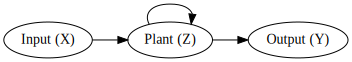

In [ ]:
g = graphviz.Digraph(name="StateObserver",format="png")
g.attr(rankdir='LR')
g.node("input",label="Input (X)")
g.node("plant",label="Plant (Z)")
g.node("output",label="Output (Y)")
g.edge("input","plant")
g.edge("plant","output")
g.edge("plant","plant")
g

In [ ]:
print(g.source)

digraph StateObserver {
	rankdir=LR
	input [label="Input (X)"]
	plant [label="Plant (Z)"]
	output [label="Output (Y)"]
	input -> plant
	plant -> output
	plant -> plant
}


In [ ]:
g.attr(dpi="600")
g.render()

'StateObserver.gv.png'

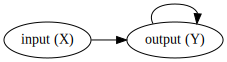

In [ ]:
g = graphviz.Digraph(name="JordanArchitecture",format="png")
g.attr(rankdir='LR')
g.node("input",label="input (X)")
g.node("output",label="output (Y)")
g.edge("output","output")
g.edge("input","output")
g

In [ ]:
g.attr(dpi="600")
g.render()

'JordanArchitecture.gv.png'

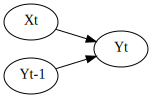

In [ ]:
g = graphviz.Digraph(name="Jordantraining",format="png")
g.attr(rankdir='LR')
g.node("currentinput",label="<X<sub>t</sub>>")
g.node("priorlabel",label="<Y<sub>t-1</sub>>")
g.node("currentlabel",label="<Y<sub>t</sub>>")
g.edge("currentinput","currentlabel")
g.edge("priorlabel","currentlabel")
g

In [ ]:
g.attr(dpi="600")
g.render()

'Jordantraining.gv.png'

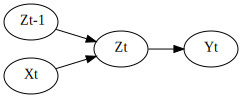

In [ ]:
g = graphviz.Digraph(name="ElmanArchitecture",format="png")
g.attr(rankdir='LR')
g.node("currentplant",label="<Z<sub>t</sub>>")
g.node("priorplant",label="<Z<sub>t-1</sub>>")
g.node("currentinput",label="<X<sub>t</sub>>")
g.node("output",label="<Y<sub>t</sub>>")
g.edge("currentinput","currentplant")
g.edge("priorplant","currentplant")
g.edge("currentplant","output")
g

In [ ]:
g.attr(dpi="600")
g.render()

'ElmanArchitecture.gv.png'

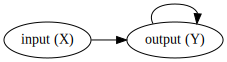

In [ ]:
g = graphviz.Digraph(name="GRUArchitecture",format="png")
g.attr(rankdir='LR')
g.node("input",label="input (X)")
g.node("output",label="output (Y)")
g.edge("input","output")
g.edge("output","output")
g

In [ ]:
g.attr(dpi="600")
g.render()

'GRUArchitecture.gv.png'

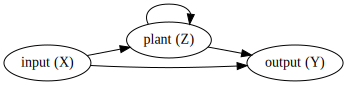

In [ ]:
g = graphviz.Digraph(name="LSTMArchitecture",format="png")
g.attr(rankdir='LR')
g.node("input",label="input (X)")
g.node("plant",label="plant (Z)")
g.node("output",label="output (Y)")
g.edge("input","plant")
g.edge("plant","plant")
g.edge("plant","output")
g.edge("input","output")
g

In [ ]:
g.attr(dpi="600")
g.render()

'LSTMArchitecture.gv.png'

## informative visuals #

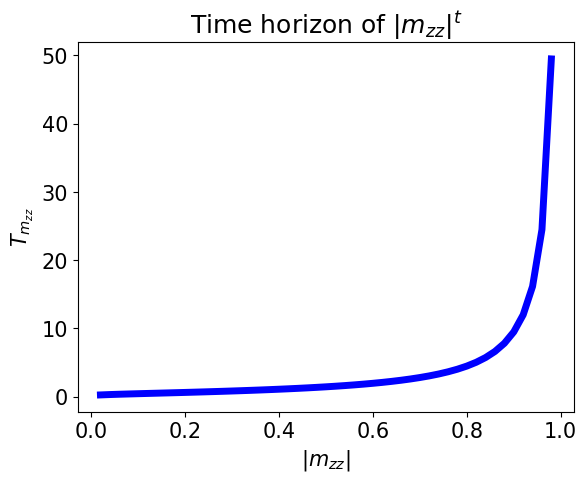

In [ ]:
alpharange=numpy.linspace(0,1,endpoint=False)
alpharange=alpharange[alpharange>0]

Timehorizon=1/numpy.log(1/alpharange)
plt.figure()
title=[]
title.append(r"Time horizon of $|m_{{zz}}|^t$")
plt.title("\n".join(title))
plt.xlabel(r"$|m_{{zz}}|$")
plt.ylabel(r"$T_{{m_{{zz}}}}$")
plt.plot(alpharange,Timehorizon,color="blue")
saver("timehorizon")
plt.show()
plt.close()

## Energy price data #

In [ ]:
text="\\begin{{center}}MISO data from \\url{{{0:s}}}\\end{{center}}"
with open("dataurl.tex","w") as f:
    f.write(text.format(url))
f.close()

In [ ]:
actual_raw=getfile(fname_actual)
actual_raw.head()

,Date,LMP,HUB
0,1/1/2023 12:00:00 AM,21.62,ILLINOIS.HUB
1,1/1/2023 12:00:00 AM,22.82,INDIANA.HUB
2,1/1/2023 12:00:00 AM,21.49,TEXAS.HUB
3,1/1/2023 12:00:00 AM,22.16,LOUISIANA.HUB
4,1/1/2023 12:00:00 AM,22.93,MICHIGAN.HUB


In [ ]:
actual_raw_ltx=actual_raw.head().style\
.format(precision=3)\
.hide(axis="index")\
.format_index(r"\textbf{{{}}}",axis="columns")\
.to_latex(hrules=True)
ptf(actual_raw_ltx,"actual")

\begin{tabular}{lrl}
\toprule
\textbf{Date} & \textbf{LMP} & \textbf{HUB} \\
\midrule
1/1/2023 12:00:00 AM & 21.620 & ILLINOIS.HUB \\
1/1/2023 12:00:00 AM & 22.820 & INDIANA.HUB \\
1/1/2023 12:00:00 AM & 21.490 & TEXAS.HUB \\
1/1/2023 12:00:00 AM & 22.160 & LOUISIANA.HUB \\
1/1/2023 12:00:00 AM & 22.930 & MICHIGAN.HUB \\
\bottomrule
\end{tabular}



In [ ]:
actual=actual_raw.copy()
actual=actual.rename(columns={"LMP":"Actual Price"})
actual["Date"]=pandas.to_datetime(actual["Date"])
actual=actual.set_index(["Date","HUB"],append=False,drop=True)

C:\Users\richa\AppData\Local\Temp\ipykernel_18892\3813914003.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  actual["Date"]=pandas.to_datetime(actual["Date"])


In [ ]:
dayahead_raw=getfile(fname_dayahead)
dayahead_raw.head()

,Date,lmp,node
0,1/1/2023 12:00:00 AM,27.10,ARKANSAS.HUB
1,1/1/2023 12:00:00 AM,27.51,ILLINOIS.HUB
2,1/1/2023 12:00:00 AM,29.05,INDIANA.HUB
3,1/1/2023 12:00:00 AM,27.73,LOUISIANA.HUB
4,1/1/2023 12:00:00 AM,28.80,MICHIGAN.HUB


In [ ]:
dayahead_raw_ltx=dayahead_raw.head().style\
.format(precision=3)\
.hide(axis="index")\
.format_index(r"\textbf{{{}}}",axis="columns")\
.to_latex(hrules=True)
ptf(dayahead_raw_ltx,"dayahead")

\begin{tabular}{lrl}
\toprule
\textbf{Date} & \textbf{lmp} & \textbf{node} \\
\midrule
1/1/2023 12:00:00 AM & 27.100 & ARKANSAS.HUB \\
1/1/2023 12:00:00 AM & 27.510 & ILLINOIS.HUB \\
1/1/2023 12:00:00 AM & 29.050 & INDIANA.HUB \\
1/1/2023 12:00:00 AM & 27.730 & LOUISIANA.HUB \\
1/1/2023 12:00:00 AM & 28.800 & MICHIGAN.HUB \\
\bottomrule
\end{tabular}



In [ ]:
dayahead=dayahead_raw.copy()
dayahead=dayahead.rename(columns={"lmp":"DayAhead Price","node":"HUB"})
dayahead["Date"]=pandas.to_datetime(dayahead["Date"])
dayahead=dayahead.set_index(["Date","HUB"],append=False,drop=True)

C:\Users\richa\AppData\Local\Temp\ipykernel_18892\3575328481.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dayahead["Date"]=pandas.to_datetime(dayahead["Date"])


In [ ]:
joined=pandas.concat([dayahead,actual],axis="columns",join="inner")
illinois=joined.query("HUB=='ILLINOIS.HUB'").sort_index(axis="index").reset_index("HUB",drop=True).copy()
illinois.head()

,DayAhead Price,Actual Price
Date,,
2023-01-01 00:00:00,27.51,21.62
2023-01-01 01:00:00,26.48,20.77
2023-01-01 02:00:00,26.36,21.23
2023-01-01 03:00:00,26.25,20.28
2023-01-01 04:00:00,25.59,18.57


In [ ]:
illinois.to_pickle("illinois.pkl")

In [ ]:
illinois_ltx=illinois.head(3).style\
.format(precision=3)\
.format_index(r"\textbf{{{}}}",axis="columns")\
.to_latex(hrules=True)
ptf(illinois_ltx,"illinois")

\begin{tabular}{lrr}
\toprule
 & \textbf{DayAhead Price} & \textbf{Actual Price} \\
Date &  &  \\
\midrule
2023-01-01 00:00:00 & 27.510 & 21.620 \\
2023-01-01 01:00:00 & 26.480 & 20.770 \\
2023-01-01 02:00:00 & 26.360 & 21.230 \\
\bottomrule
\end{tabular}



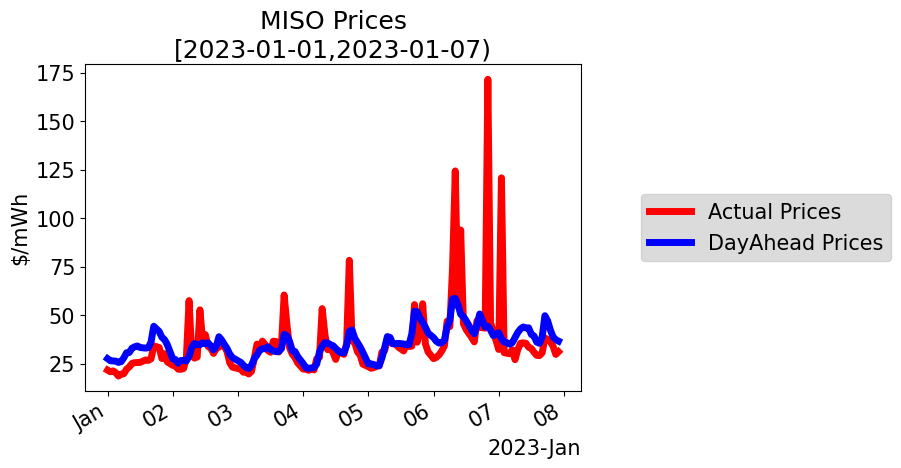

In [ ]:
DAYS=7
begin=illinois.index[0]
end=begin+datetime.timedelta(days=DAYS)
query="(Date>='{0:}') and (Date<'{1:}')".format(begin,end)
temp=illinois.query(query)
plt.figure()
plt.plot(temp.index,temp["Actual Price"],color="red",label="Actual Prices")
plt.plot(temp.index,temp["DayAhead Price"],color="blue",label="DayAhead Prices")
legend("side")
plt.ylabel("$/mWh")
plt.gcf().autofmt_xdate()
title=[]
title.append("MISO Prices")
title.append("[{:},{:})".format(temp.index[0].date(),temp.index[-1].date()))
plt.title("\n".join(title))
locator = mdates.AutoDateLocator(minticks=4, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
saver("powerprices")
plt.show()
plt.close()

In [ ]:
RNN_data=illinois.rename(columns={"DayAhead Price":"X","Actual Price":"Y"})/100
RNN_data["t"]=range(len(RNN_data))
RNN_data=RNN_data.set_index("t",append=False,drop=True)
RNN_data.index+=1
RNN_data.head()

,X,Y
t,,
1,0.2751,0.2162
2,0.2648,0.2077
3,0.2636,0.2123
4,0.2625,0.2028
5,0.2559,0.1857


In [ ]:
RNN_data_ltx=RNN_data.head().style\
.format(precision=3)\
.format_index(r"\textbf{{{}}}",axis="columns")\
.to_latex(hrules=True)
ptf(RNN_data_ltx,"RNN_data")

\begin{tabular}{lrr}
\toprule
 & \textbf{X} & \textbf{Y} \\
t &  &  \\
\midrule
1 & 0.275 & 0.216 \\
2 & 0.265 & 0.208 \\
3 & 0.264 & 0.212 \\
4 & 0.263 & 0.203 \\
5 & 0.256 & 0.186 \\
\bottomrule
\end{tabular}



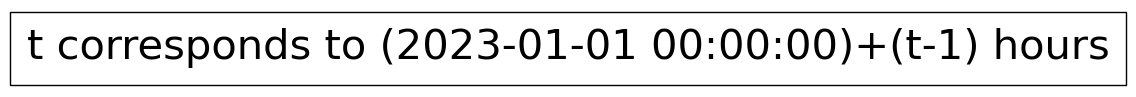

In [ ]:
text=["t corresponds to ({:})+(t-1) hours".format(min(illinois.index))]
textbox(text,"timeshift")

## Jordan network #

In [ ]:
Jordan=RNN_data.copy()
Jordan["lagged Y"]=Jordan["Y"].shift()
Jordan=Jordan[["X","lagged Y","Y"]]
Jordan=Jordan.dropna(axis='index')
Jordan.columns=pandas.MultiIndex.from_tuples(zip(["Feature","Feature","Label"],Jordan.columns))
Jordan.head()

Feature            Label
        X lagged Y       Y
t                         
2  0.2648   0.2162  0.2077
3  0.2636   0.2077  0.2123
4  0.2625   0.2123  0.2028
5  0.2559   0.2028  0.1857
6  0.2598   0.1857  0.1948

In [ ]:
Jordan_ltx=Jordan.head(3).style\
.format(precision=3)\
.format_index(r"\textbf{{{}}}",axis="columns")\
.to_latex(hrules=True)
ptf(Jordan_ltx,"Jordan")


\begin{tabular}{lrrr}
\toprule
 & \multicolumn{2}{r}{\textbf{Feature}} & \textbf{Label} \\
 & \textbf{X} & \textbf{lagged Y} & \textbf{Y} \\
t &  &  &  \\
\midrule
2 & 0.265 & 0.216 & 0.208 \\
3 & 0.264 & 0.208 & 0.212 \\
4 & 0.263 & 0.212 & 0.203 \\
\bottomrule
\end{tabular}



## Elman Network #

In [ ]:
Elman_data=RNN_data.head(3).copy()
Elman_data

,X,Y
t,,
1,0.2751,0.2162
2,0.2648,0.2077
3,0.2636,0.2123


In [ ]:
Elman_data_ltx=Elman_data.head(3).style\
.format(precision=3)\
.format_index(r"\textbf{{{}}}",axis="columns")\
.to_latex(hrules=True)
ptf(Elman_data_ltx,"Elman")

\begin{tabular}{lrr}
\toprule
 & \textbf{X} & \textbf{Y} \\
t &  &  \\
\midrule
1 & 0.275 & 0.216 \\
2 & 0.265 & 0.208 \\
3 & 0.264 & 0.212 \\
\bottomrule
\end{tabular}



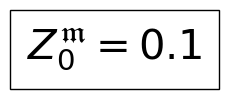

In [ ]:
z_init=0.1
text=[r"$Z^{{\mathfrak{{m}}}}_{{0}}={0:.1f}$".format(z_init)]
textbox(text,fname="initialElman")

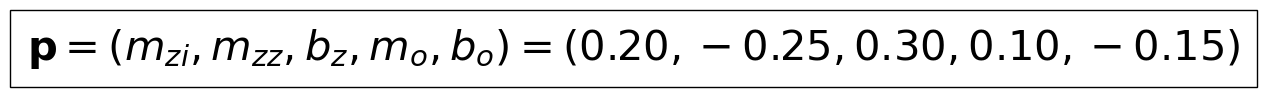

In [ ]:
parameters=(0.2,-0.25,0.3,0.1,-0.15)
(m_zi,m_zz,b_z,m_o,b_o)=parameters
text=[r"$\mathbf{{p}}=(m_{{zi}},m_{{zz}},b_z,m_o,b_o)=({0:.2f},{1:.2f},{2:.2f},{3:.2f},{4:.2f})$".format(*parameters)]
textbox(text,fname="sampleparams")

In [ ]:
def generate(parameters,show_hidden_state=False):
    (m_zi,m_zz,b_z,m_o,b_o)=parameters
    out=Elman_data.copy()
    out.loc[0,:]=numpy.nan
    out=out.sort_index()
    #out=out.to_frame()
    z_state=z_init
    z=[z_init]
    Y=[numpy.nan]
    for xx in out["X"][1:]:
        z_state=numpy.tanh(m_zz*z_state+m_zi*xx+b_z)
        Y_current=numpy.tanh(m_o*z_state+b_o)
        z.append(z_state)
        Y.append(Y_current)
    if show_hidden_state:
        out["ZM"]=z
    out["YM"]=Y
    return out

generated_data=generate(parameters,show_hidden_state=True)
generated_data=generated_data[["X","ZM","YM","Y"]]
generated_data

,X,ZM,YM,Y
t,,,,
0,NaN,0.100000,NaN,NaN
1,0.2751,0.318539,-0.117599,0.2162
2,0.2648,0.266716,-0.122707,0.2077
3,0.2636,0.278487,-0.121547,0.2123


In [ ]:
loss=numpy.mean((Elman_data["Y"]-generated_data["YM"])**2)
loss

0.11068162093340432

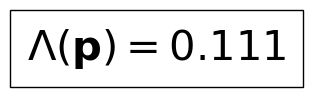

In [ ]:
text=[]
text.append(r"$\Lambda(\mathbf{{p}})={:.3f}$".format(loss))
textbox(text,fname="lossvalue")

In [ ]:
g=generated_data.copy()
g

,X,ZM,YM,Y
t,,,,
0,NaN,0.100000,NaN,NaN
1,0.2751,0.318539,-0.117599,0.2162
2,0.2648,0.266716,-0.122707,0.2077
3,0.2636,0.278487,-0.121547,0.2123


In [ ]:
g.columns=["$X$","$Z^{\mathfrak{m}}$","$Y^{\mathfrak{m}}$","$Y$"]
g_ltx=g.style\
.format(precision=3)\
.to_latex(hrules=True)
ptf(g_ltx,"Hidden")

\begin{tabular}{lrrrr}
\toprule
 & $X$ & $Z^{\mathfrak{m}}$ & $Y^{\mathfrak{m}}$ & $Y$ \\
t &  &  &  &  \\
\midrule
0 & nan & 0.100 & nan & nan \\
1 & 0.275 & 0.319 & -0.118 & 0.216 \\
2 & 0.265 & 0.267 & -0.123 & 0.208 \\
3 & 0.264 & 0.278 & -0.122 & 0.212 \\
\bottomrule
\end{tabular}



In [ ]:
temp=(Elman_data["Y"]-generated_data["YM"])*(1-(numpy.tanh(m_o*generated_data["ZM"]+b_o))**2)
temp

t
0         NaN
1    0.329183
2    0.325432
3    0.328915
dtype: float64

In [ ]:
dLossdb_o=-2*numpy.nanmean(temp)
dLossdw_o=-2*numpy.nanmean(temp*generated_data["YM"])

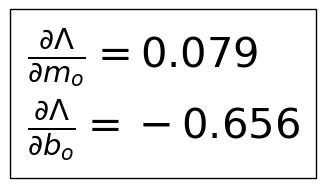

In [ ]:
text=[]
text.append(r"$\frac{{\partial \Lambda}}{{\partial m_o}}={:.3f}$".format(dLossdw_o))
text.append(r"$\frac{{\partial \Lambda}}{{\partial b_o}}={:.3f}$".format(dLossdb_o))
textbox(text,fname="firstlosses")

In [ ]:
forcing=pandas.DataFrame({"dm_zi":generated_data["X"],"dm_zz":generated_data["ZM"].shift(),
                         "db_z":1})
forcing

,dm_zi,dm_zz,db_z
t,,,
0,NaN,NaN,1
1,0.2751,0.100000,1
2,0.2648,0.318539,1
3,0.2636,0.266716,1


In [ ]:
multiplier=1-(numpy.tanh(m_zi*generated_data["X"]+m_zz*generated_data["ZM"].shift()+b_z))**2
multiplier

t
0         NaN
1    0.898533
2    0.928862
3    0.922445
dtype: float64

In [ ]:
dZ=pandas.DataFrame(float(0),index=forcing.index,columns=forcing.columns)
for t in dZ.index[1:]:
    dZ.loc[t,:]=multiplier.loc[t]*m_zz*dZ.loc[t-1,:]+forcing.loc[t,:]
dZ

,dm_zi,dm_zz,db_z
t,,,
0,0.000000,0.000000,0.000000
1,0.275100,0.100000,1.000000
2,0.200917,0.295317,0.767784
3,0.217266,0.198613,0.822940


In [ ]:
dLossdm_zz=-2*numpy.nanmean(temp*m_o*dZ["dm_zz"])
dLossdm_zi=-2*numpy.nanmean(temp*m_o*dZ["dm_zi"])
dLossdb_z=-2*numpy.nanmean(temp*m_o*dZ["db_z"])

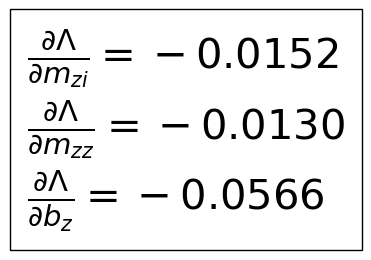

In [ ]:
text=[]
text.append(r"$\frac{{\partial \Lambda}}{{\partial m_{{zi}}}}={:.4f}$".format(dLossdm_zi))
text.append(r"$\frac{{\partial \Lambda}}{{\partial m_{{zz}}}}={:.4f}$".format(dLossdm_zz))
text.append(r"$\frac{{\partial \Lambda}}{{\partial b_z}}={:.4f}$".format(dLossdb_z))
textbox(text,fname="secondlosses")